<p style="text-align:center">
    <a href="https://skills.network" target="_blank">
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/assets/logos/SN_web_lightmode.png" width="200" alt="Skills Network Logo"  />
    </a>
</p>


# **Lab: Building Advanced Transformers**

**Estimated time needed:  30 minutes**  

In this lab, you will implement and experiment with advanced Transformer models using Keras. 

**Learning objectives:** 

By the end of this lab, you will: 

- Implement advanced Transformer models using Keras. 

- Apply Transformers to real-world sequential data tasks. 

- Build, train, and evaluate Transformer models. 


## Step-by-Step Instructions: 

### Step 1: Import necessary libraries 

Before you start, you need to import the required libraries: TensorFlow and Keras. Keras is included within TensorFlow as `tensorflow.keras.`


In [1]:
import numpy as np 
import pandas as pd 
import tensorflow as tf 
import requests
from sklearn.preprocessing import MinMaxScaler 
from tensorflow.keras.layers import Layer, Dense, LayerNormalization, Dropout

####  Setup the Environment to generate synthetic stock price data


In [2]:
import numpy as np
import pandas as pd

# Create a synthetic stock price dataset
np.random.seed(42)
data_length = 2000  # Adjust data length as needed
trend = np.linspace(100, 200, data_length)
noise = np.random.normal(0, 2, data_length)
synthetic_data = trend + noise

# Create a DataFrame and save as 'stock_prices.csv'
data = pd.DataFrame(synthetic_data, columns=['Close'])
data.to_csv('stock_prices.csv', index=False)
print("Synthetic stock_prices.csv created and loaded.")


Synthetic stock_prices.csv created and loaded.


In [28]:
# Load the dataset 
data = pd.read_csv('stock_prices.csv') 
data = data[['Close']].values

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
data = scaler.fit_transform(data)

# Prepare the data for training
def create_dataset(data, time_step=1):
    X, Y = [], []

    for i in range(len(data)-time_step-1):
        a = data[i:(i+time_step), 0]
        X.append(a)
        Y.append(data[i + time_step, 0])
    return np.array(X), np.array(Y)

time_step = 100
X, Y = create_dataset(data, time_step)
X = X.reshape(X.shape[0], X.shape[1], 1)

print("Shape of X:", X.shape) 
print("Shape of Y:", Y.shape) 

Shape of X: (1899, 100, 1)
Shape of Y: (1899,)


In the above code: 

`tensorflow` is the main library for machine learning in Python.  

`stock_prices.csv` is the data set that is loaded. 

`MinMaxScaler` method is used to normalize the data.  

`create_dataset`method is used to prepare the data for training. 


### Step 2: Implement Multi-Head Self-Attention 

Define the Multi-Head Self-Attention mechanism. 


In [7]:
class MultiHeadSelfAttention(Layer): 

    def __init__(self, embed_dim, num_heads=8): 
        super(MultiHeadSelfAttention, self).__init__() 
        self.embed_dim = embed_dim 
        self.num_heads = num_heads 
        self.projection_dim = embed_dim // num_heads 
        self.query_dense = Dense(embed_dim) 
        self.key_dense = Dense(embed_dim) 
        self.value_dense = Dense(embed_dim) 
        self.combine_heads = Dense(embed_dim) 


    def attention(self, query, key, value): 
        score = tf.matmul(query, key, transpose_b=True) 
        dim_key = tf.cast(tf.shape(key)[-1], tf.float32) 
        scaled_score = score / tf.math.sqrt(dim_key) 
        weights = tf.nn.softmax(scaled_score, axis=-1) 
        output = tf.matmul(weights, value) 
        return output, weights 

    def split_heads(self, x, batch_size): 
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.projection_dim)) 
        return tf.transpose(x, perm=[0, 2, 1, 3]) 

    def call(self, inputs): 
        batch_size = tf.shape(inputs)[0] 
        query = self.query_dense(inputs) 
        key = self.key_dense(inputs) 
        value = self.value_dense(inputs) 
        query = self.split_heads(query, batch_size) 
        key = self.split_heads(key, batch_size) 
        value = self.split_heads(value, batch_size) 
        attention, _ = self.attention(query, key, value) 
        attention = tf.transpose(attention, perm=[0, 2, 1, 3]) 
        concat_attention = tf.reshape(attention, (batch_size, -1, self.embed_dim)) 
        output = self.combine_heads(concat_attention) 
        return output 

 

In the above code: 

- The MultiHeadSelfAttention layer implements the multi-head self-attention mechanism, which allows the model to focus on different parts of the input sequence simultaneously. 

- The attention parameter computes the attention scores and weighted sum of the values. 

- The split_heads parameter splits the input into multiple heads for parallel attention computation. 

- The call method applies the self-attention mechanism and combines the heads. 


### Step 3: Implement Transformer block 

Define the Transformer block. 


In [8]:
class TransformerBlock(Layer): 

    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1): 
        super(TransformerBlock, self).__init__() 
        self.att = MultiHeadSelfAttention(embed_dim, num_heads) 
        self.ffn = tf.keras.Sequential([ 
            Dense(ff_dim, activation="relu"), 
            Dense(embed_dim), 
        ]) 

        self.layernorm1 = LayerNormalization(epsilon=1e-6) 
        self.layernorm2 = LayerNormalization(epsilon=1e-6) 
        self.dropout1 = Dropout(rate) 
        self.dropout2 = Dropout(rate) 


    def call(self, inputs, training): 
        attn_output = self.att(inputs) 
        attn_output = self.dropout1(attn_output, training=training) 
        out1 = self.layernorm1(inputs + attn_output) 
        ffn_output = self.ffn(out1) 
        ffn_output = self.dropout2(ffn_output, training=training) 
        return self.layernorm2(out1 + ffn_output) 

In the above code:

- The TransformerBlock layer combines multi-head self-attention with a feed-forward neural network and normalization layers.  

- Dropout is used to prevent overfitting. 

- The call method applies the self-attention, followed by the feedforward network with residual connections and layer normalization.


### Step 4: Implement Encoder Layer 

Define the Encoder layer. 


In [9]:
class EncoderLayer(Layer): 

    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1): 
        super(EncoderLayer, self).__init__() 
        self.att = MultiHeadSelfAttention(embed_dim, num_heads) 
        self.ffn = tf.keras.Sequential([ 
            Dense(ff_dim, activation="relu"), 
            Dense(embed_dim), 
        ]) 

        self.layernorm1 = LayerNormalization(epsilon=1e-6) 
        self.layernorm2 = LayerNormalization(epsilon=1e-6) 
        self.dropout1 = Dropout(rate) 
        self.dropout2 = Dropout(rate) 

 

    def call(self, inputs, training): 
        attn_output = self.att(inputs) 
        attn_output = self.dropout1(attn_output, training=training) 
        out1 = self.layernorm1(inputs + attn_output) 
        ffn_output = self.ffn(out1) 
        ffn_output = self.dropout2(ffn_output, training=training) 
        return self.layernorm2(out1 + ffn_output) 



In the above code: 

- The EncoderLayer is similar to the TransformerBlock but is a reusable layer in the Transformer architecture. 

- It consists of a MultiHeadSelfAttention mechanism followed by a feedforward neural network. 

- Both sub-layers have residual connections around them, and layer normalization is applied to the output of each sub-layer. 

- The call method applies the self-attention, followed by the feedforward network, with residual connections and layer normalization. 


### Step 5: Implement Transformer encoder 

Define the Transformer Encoder. 


In [10]:
import tensorflow as tf 
from tensorflow.keras.layers import Layer, Dense, LayerNormalization, Dropout 

class MultiHeadSelfAttention(Layer): 
    def __init__(self, embed_dim, num_heads=8): 
        super(MultiHeadSelfAttention, self).__init__() 
        self.embed_dim = embed_dim 
        self.num_heads = num_heads 
        self.projection_dim = embed_dim // num_heads 
        self.query_dense = Dense(embed_dim) 
        self.key_dense = Dense(embed_dim) 
        self.value_dense = Dense(embed_dim) 
        self.combine_heads = Dense(embed_dim) 
 

    def attention(self, query, key, value): 
        score = tf.matmul(query, key, transpose_b=True) 
        dim_key = tf.cast(tf.shape(key)[-1], tf.float32) 
        scaled_score = score / tf.math.sqrt(dim_key) 
        weights = tf.nn.softmax(scaled_score, axis=-1) 
        output = tf.matmul(weights, value) 
        return output, weights 


    def split_heads(self, x, batch_size): 
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.projection_dim)) 
        return tf.transpose(x, perm=[0, 2, 1, 3]) 


    def call(self, inputs): 
        batch_size = tf.shape(inputs)[0] 
        query = self.query_dense(inputs) 
        key = self.key_dense(inputs) 
        value = self.value_dense(inputs) 
        query = self.split_heads(query, batch_size) 
        key = self.split_heads(key, batch_size) 
        value = self.split_heads(value, batch_size) 
        attention, _ = self.attention(query, key, value) 
        attention = tf.transpose(attention, perm=[0, 2, 1, 3]) 
        concat_attention = tf.reshape(attention, (batch_size, -1, self.embed_dim)) 
        output = self.combine_heads(concat_attention) 
        return output 

class TransformerBlock(Layer): 
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1): 
        super(TransformerBlock, self).__init__() 
        self.att = MultiHeadSelfAttention(embed_dim, num_heads) 
        self.ffn = tf.keras.Sequential([ 
            Dense(ff_dim, activation="relu"), 
            Dense(embed_dim), 
        ]) 

        self.layernorm1 = LayerNormalization(epsilon=1e-6) 
        self.layernorm2 = LayerNormalization(epsilon=1e-6) 
        self.dropout1 = Dropout(rate) 
        self.dropout2 = Dropout(rate) 
 

    def call(self, inputs, training): 
        attn_output = self.att(inputs) 
        attn_output = self.dropout1(attn_output, training=training) 
        out1 = self.layernorm1(inputs + attn_output) 
        ffn_output = self.ffn(out1) 
        ffn_output = self.dropout2(ffn_output, training=training) 
        return self.layernorm2(out1 + ffn_output) 

class TransformerEncoder(Layer): 
    def __init__(self, num_layers, embed_dim, num_heads, ff_dim, rate=0.1): 
        super(TransformerEncoder, self).__init__() 
        self.num_layers = num_layers 
        self.embed_dim = embed_dim 
        self.enc_layers = [TransformerBlock(embed_dim, num_heads, ff_dim, rate) for _ in range(num_layers)] 
        self.dropout = Dropout(rate) 

    def call(self, inputs, training=False): 
        x = inputs 
        for i in range(self.num_layers): 
            x = self.enc_layers[i](x, training=training) 
        return x 

# Example usage 
embed_dim = 128 
num_heads = 8 
ff_dim = 512 
num_layers = 4 

transformer_encoder = TransformerEncoder(num_layers, embed_dim, num_heads, ff_dim) 
inputs = tf.random.uniform((1, 100, embed_dim)) 
outputs = transformer_encoder(inputs, training=False)  # Use keyword argument for 'training' 
print(outputs.shape)  # Should print (1, 100, 128) 

(1, 100, 128)


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'transformer_encoder', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


In the above code: 

The TransformerEncoder is composed of multiple TransformerBlock layers, implementing the encoding part of the Transformer architecture. 


### Step 6: Build and Compile the Transformer model 

Integrate the Transformer Encoder into a complete model for sequential data. 


In [11]:
# Define the necessary parameters 

embed_dim = 128 
num_heads = 8 
ff_dim = 512 
num_layers = 4 

# Define the Transformer Encoder 
transformer_encoder = TransformerEncoder(num_layers, embed_dim, num_heads, ff_dim) 

# Build the model 
input_shape = (X.shape[1], X.shape[2]) 
inputs = tf.keras.Input(shape=input_shape) 

# Project the inputs to the embed_dim 
x = tf.keras.layers.Dense(embed_dim)(inputs) 
encoder_outputs = transformer_encoder(x) 
flatten = tf.keras.layers.Flatten()(encoder_outputs) 
outputs = tf.keras.layers.Dense(1)(flatten) 
model = tf.keras.Model(inputs, outputs) 

# Compile the model 
model.compile(optimizer='adam', loss='mse') 

# Summary of the model 
model.summary() 


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'transformer_encoder_1', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 100, 1)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_48 (Dense)                │ (None, 100, 128)       │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_encoder_1           │ (None, 100, 128)       │       793,088 │
│ (TransformerEncoder)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_49 (Dense)                │ (None, 1)              │        12,801 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 806,145 (3.08 MB)

 Trainable params: 806,145 (3.08 MB)

 Non-trainable params: 0 (0.00 B)

In the above code: 

- The Transformer Encoder model defines the necessary parameters, flattens the output, and ends with a dense layer to produce the final output.  

- The model is then compiled with the Adam optimizer and mean squared error loss. 


### Step 7: Train the Transformer model 

Train the model on the prepared dataset. 


In [12]:
# Train the model
model.fit(X, Y, epochs=20, batch_size=32)


Epoch 1/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 14s 172ms/step - loss: 14.4000
Epoch 2/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 10s 170ms/step - loss: 0.2027
Epoch 3/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 11s 177ms/step - loss: 0.2185
Epoch 4/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 11s 177ms/step - loss: 0.1516
Epoch 5/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 11s 176ms/step - loss: 0.1355
Epoch 6/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 11s 177ms/step - loss: 0.1587
Epoch 7/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 11s 186ms/step - loss: 0.1577
Epoch 8/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 11s 178ms/step - loss: 0.2174
Epoch 9/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 11s 185ms/step - loss: 0.1290
Epoch 10/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 11s 179ms/step - loss: 0.1445
Epoch 11/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 11s 180ms/step - loss: 0.0950
Epoch 12/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 11s 179ms/step - loss: 0.0859
Epoch 13/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 11s 181ms/step - loss: 0.1224
Epoch 14/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 11s 182ms/step - loss: 0.0947
Epoch 15/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 11s

In the above code: 

The model is trained on the normalized stock price data for 20 epochs with a batch size of 32. 


### Step 8: Evaluate and Make Predictions 

Evaluate the model's performance and make predictions on the dataset. 


60/60 ━━━━━━━━━━━━━━━━━━━━ 4s 71ms/step


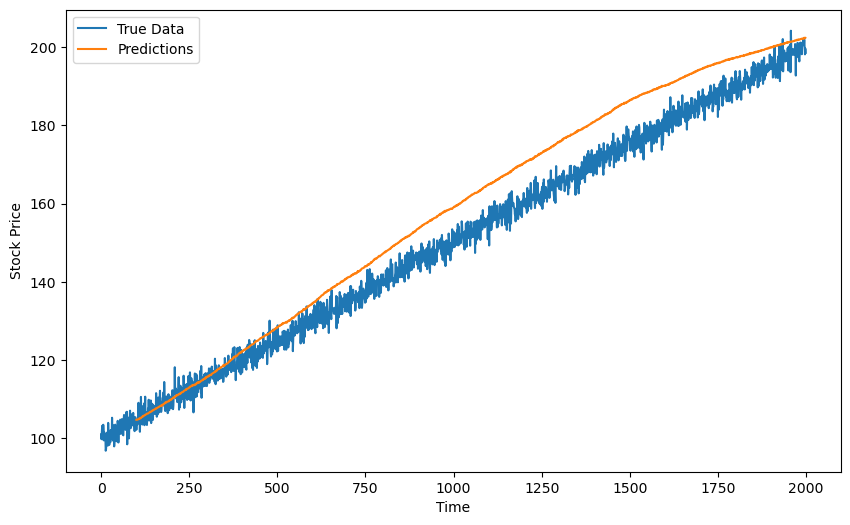

In [29]:
# Make predictions 
predictions = model.predict(X) 
predictions = scaler.inverse_transform(predictions) 

true_data = scaler.inverse_transform(data) 
 

# Plot the predictions 
import matplotlib.pyplot as plt 

plt.figure(figsize=(10, 6))
plt.plot(true_data, label='True Data') 
plt.plot(np.arange(time_step, time_step + len(predictions)), predictions, label='Predictions') 
plt.xlabel('Time') 
plt.ylabel('Stock Price') 
plt.legend() 
plt.show() 

 

In the above code: 

- The model's predictions are transformed back to the original scale using the inverse transform of the scaler. 

- The true data and predictions are plotted to visualize the model's performance. 


## Practice Exercises: 

 ### Exercise 1: Add dropout to the Transformer model 

 **Objective: Understand how to add dropout layers to the Transformer model to prevent overfitting.** 

 Instructions: 

- Add a dropout layer after the Flatten layer in the model. 

- Set the dropout rate to 0.5. 


In [ ]:
flatten = tf.keras.layers.Flatten()(encoder_outputs) 
dropout = tf.keras.layers.Dropout(rate=0.5)(flatten)
outputs = tf.keras.layers.Dense(1)(dropout) 
model = tf.keras.Model(inputs, outputs) 

# Compile the model 
model.compile(optimizer='adam', loss='mse') 

# Train the model
model.fit(X, Y, epochs=20, batch_size=32)

# Evaluate the model
loss = model.evaluate(X, Y)

print(loss)

Epoch 1/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 14s 162ms/step - loss: 4.5260
Epoch 2/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 10s 162ms/step - loss: 1.0942
Epoch 3/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 10s 167ms/step - loss: 0.5409
Epoch 4/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 10s 165ms/step - loss: 0.1853
Epoch 5/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 10s 167ms/step - loss: 0.0812
Epoch 6/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 10s 173ms/step - loss: 0.0512
Epoch 7/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 10s 169ms/step - loss: 0.0455
Epoch 8/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 10s 171ms/step - loss: 0.0404
Epoch 9/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 10s 167ms/step - loss: 0.0346
Epoch 10/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 11s 176ms/step - loss: 0.0277
Epoch 11/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 13s 217ms/step - loss: 0.0267
Epoch 12/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 13s 213ms/step - loss: 0.0218
Epoch 13/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 12s 198ms/step - loss: 0.0269
Epoch 14/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 11s 177ms/step - loss: 0.0205
Epoch 15/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 11s 

60/60 ━━━━━━━━━━━━━━━━━━━━ 5s 72ms/step


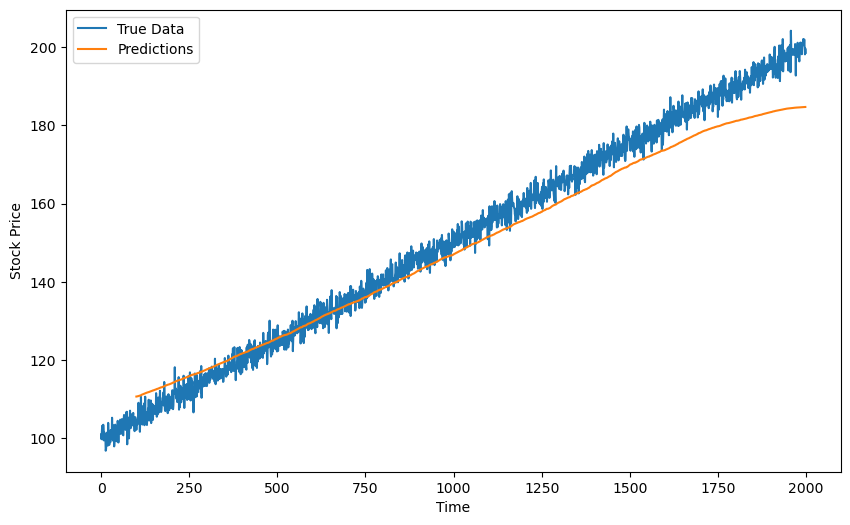

In [32]:
# Make predictions 
predictions = model.predict(X) 
predictions = scaler.inverse_transform(predictions) 

true_data = scaler.inverse_transform(data) 
 

# Plot the predictions 
import matplotlib.pyplot as plt 

plt.figure(figsize=(10, 6))
plt.plot(true_data, label='True Data') 
plt.plot(np.arange(time_step, time_step + len(predictions)), predictions, label='Predictions') 
plt.xlabel('Time') 
plt.ylabel('Stock Price') 
plt.legend() 
plt.show() 

### Exercise 2: Experiment with different batch sizes 

**Objective: Observe the impact of different batch sizes on model performance.** 

 Instructions: 

- Train the model with a batch size of 16. 

- Train the model with a batch size of 64. 

- Compare the training time and performance. 


In [ ]:
#Training the model with batch sise of 16
model_16 = tf.keras.Model(inputs, outputs) 
 
model_16.compile(optimizer='adam', loss='mse') 

model_16.fit(X, Y, epochs=20, batch_size=16)

loss_16 = model_16.evaluate(X, Y)

#Training the model with batch sise of 64
model_64 = tf.keras.Model(inputs, outputs) 
 
model_64.compile(optimizer='adam', loss='mse') 

model_64.fit(X, Y, epochs=20, batch_size=64)

loss_64 = model_64.evaluate(X, Y)

print(f'Test loss with batch size 16: {loss_16}')
print(f'Test loss with batch size 64: {loss_64}')

Epoch 1/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 16s 86ms/step - loss: 0.0176
Epoch 2/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 10s 84ms/step - loss: 0.0021
Epoch 3/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 10s 84ms/step - loss: 0.0021
Epoch 4/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 10s 86ms/step - loss: 0.0023
Epoch 5/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 10s 86ms/step - loss: 0.0029
Epoch 6/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 10s 85ms/step - loss: 0.0037
Epoch 7/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 10s 84ms/step - loss: 0.0045
Epoch 8/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 10s 87ms/step - loss: 0.0027
Epoch 9/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 10s 85ms/step - loss: 0.0026
Epoch 10/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 10s 86ms/step - loss: 0.0024
Epoch 11/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 11s 89ms/step - loss: 0.0047
Epoch 12/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 11s 92ms/step - loss: 0.0025
Epoch 13/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 10s 88ms/step - loss: 0.0026
Epoch 14/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 13s 110ms/step - loss: 0.0025
Epoch 15/20
119/119 ━━━━━━━━

60/60 ━━━━━━━━━━━━━━━━━━━━ 4s 65ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 4s 66ms/step


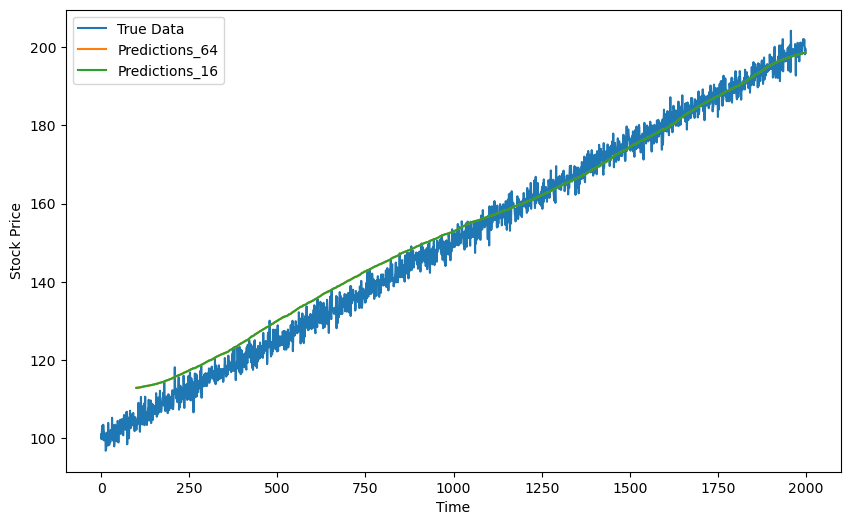

In [ ]:
# Make predictions for model trained on batch size of 16
predictions_16 = model_16.predict(X) 
predictions_16 = scaler.inverse_transform(predictions_16) 

# Make predictions for model trained on batch size of 64
predictions_64 = model_64.predict(X) 
predictions_64 = scaler.inverse_transform(predictions_64) 

true_data = scaler.inverse_transform(data) 
 

# Plot the predictions 
import matplotlib.pyplot as plt 

plt.figure(figsize=(10, 6))
plt.plot(true_data, label='True Data') 
plt.plot(np.arange(time_step, time_step + len(predictions_16)), predictions_16, label='Predictions_16') 
plt.plot(np.arange(time_step, time_step + len(predictions_64)), predictions_64, label='Predictions_64') 
plt.xlabel('Time') 
plt.ylabel('Stock Price') 
plt.legend() 
plt.show() 

### Exercise 3: Use a different activation function 

 **Objective: Understand how different activation functions impact the model performance.** 

 Instructions: 

- Change the activation function of the Dense layer to `tanh`. 

- Train and evaluate the model. 


In [ ]:
outputs = tf.keras.layers.Dense(1, activation='tanh')(dropout) 
new_model = tf.keras.Model(inputs, outputs) 

# Compile the model 
new_model.compile(optimizer='adam', loss='mse') 

# Train the model
new_model.fit(X, Y, epochs=20, batch_size=32)

# Evaluate the model
loss = new_model.evaluate(X, Y)

print(loss)

In [ ]:
# Make predictions 
predictions = new_model.predict(X) 
predictions = scaler.inverse_transform(predictions) 

true_data = scaler.inverse_transform(data) 
 

# Plot the predictions 
import matplotlib.pyplot as plt 

plt.figure(figsize=(10, 6))
plt.plot(true_data, label='True Data') 
plt.plot(np.arange(time_step, time_step + len(predictions)), predictions, label='Predictions') 
plt.xlabel('Time') 
plt.ylabel('Stock Price') 
plt.legend() 
plt.show() 

## Conclusion
Congratulations on completing this lab! In this lab, you have built an advanced Transformer model using Keras and applied it to a time series forecasting task. You have learned how to define and implement multi-head self-attention, Transformer blocks, encoder layers, and integrate them into a complete Transformer model. By experimenting with different configurations and training the model, you can further improve its performance and apply it to various sequential data tasks. 


Copyright © IBM Corporation. All rights reserved.
